In [1]:
# venv
import torch
import datetime as dt
print(torch.__version__)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

2.0.1+cu117
GPU is available.


In [1]:
import os, subprocess, glob, srt, pickle
from shutil import rmtree
import cv2
import demoTalkNetMod
from utils import custom_components
# import logging
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import srt
import whisper

from stable_whisper import modify_model
from pyannote.core import Segment, Annotation
from pyannote.core import notebook
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()
import torch
from pyannote.audio import Pipeline
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# logger = logging.getLogger("transcribe")

pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.0",
                                               use_auth_token=os.getenv('HUGGINGFACE_TOKEN'))
pretrained_pipeline.to(torch.device("cuda"))
# sys.path.append(os.path.abspath("TalkNet-ASD/"))

2024-02-13 18:37:27.351839324 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-02-13 18:37:27.351864050 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [2]:
class Args:
    def __init__(self, args_dict):
        self.__dict__.update(args_dict)

args_dict = {
    "videoFolder":"Dataset/Videos",
    "videoOutputFolder":"output/video_temp",
    "pretrainModel":"pretrain_TalkSet.model",
    "nDataLoaderThread":10,
    "facedetScale":0.25,
    "minTrack":10,
    "numFailedDet":10,
    "minFaceSize":1,
    "cropScale":0.40,
    "start":0,
    "duration":0,
    "evalCol":False,
    "colSavePath":"/data08/col",
}

args = Args(args_dict)

if os.path.isfile(args.pretrainModel) == False:  # Download the pretrained model
    Link = "1AbN9fCf9IexMxEKXLQY2KYBlb-IhSEea"
    cmd = "gdown --id %s -O %s" % (Link, args.pretrainModel)
    subprocess.call(cmd, shell=True, stdout=None)


model_name_openai = "medium.en"
model = custom_components.get_whisper_model(model_name_openai)

args.videoFiles = [
    os.path.splitext(f)[0]
    for f in os.listdir(args.videoFolder)
    if os.path.isfile(os.path.join(args.videoFolder, f)) and os.path.splitext(os.path.join(args.videoFolder, f))[1] in [".mp4"]
]

args.runOutputFolder = f"output/run_output/{datetime.now().strftime('%Y%m%d_%H%M')}"
if os.path.exists(args.runOutputFolder):
    rmtree(args.runOutputFolder)
os.mkdir(args.runOutputFolder)

args.videoFiles = ['NDT_India_19_88']

In [3]:
args.videoFiles

['NDT_India_19_88']

In [4]:
final_video_output = {}
for video_file in args.videoFiles:
    print(video_file)
    args.videoPath = glob.glob(
        os.path.join(args.videoFolder, video_file + ".*")
    )[0]
    args.savePath = os.path.join(args.videoOutputFolder, video_file)
    args.audioFilePath = os.path.join(args.savePath, "pyavi", "audio.wav")
    video = cv2.VideoCapture(args.videoPath)
    args.frameRate = video.get(cv2.CAP_PROP_FPS)
    video.release()
    print(args.frameRate)

    vidTracks, scores, args = demoTalkNetMod.preprocess(args)

    df, args = demoTalkNetMod.get_track_face_encodings(vidTracks, scores, args)
    print(args.frameRate)

    optimal_cluster = -1
    max_silhouette = 0
    encoding_list = df["Encoding"].to_list()
    for num_clusters in range(2, 6):
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(encoding_list)

        silhouette_avg = silhouette_score(encoding_list, cluster_labels)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            optimal_cluster = num_clusters

    print(optimal_cluster)
    kmeans = KMeans(n_clusters=optimal_cluster, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(encoding_list)

    df["Clusters"] = cluster_labels

    video_output = demoTalkNetMod.get_final_tracks(df, args)

    custom_components.create_annotation_plot(
        speaker_timelines=video_output,
        save_folder=args.savePath,
        file_name="video_diarization_output",
        video_duration = args.video_duration,
        plot_name="Video Diarization_output"
    )

    final_video_output[video_file] = video_output

with open(
    os.path.join(args.runOutputFolder, "video_diarization_output.pckl"), "wb"
) as fil:
    pickle.dump(final_video_output, fil)

final_video_output

NDT_India_19_88
29.97002997002997


2024-02-13 18:38:17 Extract the video and save in output/video_temp/NDT_India_19_88/pyavi/video.avi 
2024-02-13 18:38:17 Extract the audio and save in output/video_temp/NDT_India_19_88/pyavi/audio.wav 
2024-02-13 18:38:28 Extract the frames and save in output/video_temp/NDT_India_19_88/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/video_temp/NDT_India_19_88/pyavi/video.avi - scenes detected 5
2024-02-13 18:38:36 Scene detection and save in output/video_temp/NDT_India_19_88/pywork 
2024-02-13 18:40:33 Face detection and save in output/video_temp/NDT_India_19_88/pywork 
2024-02-13 18:40:33 Face track and detected 36 tracks 
100%|█████████████████████████████████████████████████

02-13 18:42:11 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.82it/s]
2024-02-13 18:42:24 Scores extracted and saved in output/video_temp/NDT_India_19_88/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [07:42<00:00,  2.57faces/s]
2024-02-13 18:50:07 Face encoding generation completed

25.033300515434068
5


{'NDT_India_19_88': {'SPEAKER_04': [(6.47, 6.95)],
  'SPEAKER_02': [(3.24, 6.43), (6.99, 15.98)],
  'SPEAKER_00': [(16.42, 24.53)],
  'SPEAKER_01': [(35.47, 35.95),
   (42.02, 58.96),
   (59.4, 63.24),
   (68.47, 68.95)],
  'SPEAKER_03': [(37.11, 41.11)]}}

In [5]:
final_audio_output = {}
for video_file in args.videoFiles:
    print(video_file)
    args.videoPath = glob.glob(os.path.join(args.videoFolder, video_file + ".*"))[0]
    args.savePath = os.path.join(args.videoOutputFolder, video_file)
    args.audioPath = os.path.join(args.savePath, "pyavi", "audio.wav")

    diarization = pretrained_pipeline(args.audioPath)

    audio_output = {}
    for duration, _, speaker_key in diarization.itertracks(yield_label=True):
        if speaker_key in audio_output.keys():
            audio_output[speaker_key].append((round(duration.start, 2), round(duration.end, 2)))
        else:
            audio_output[speaker_key] = [(round(duration.start, 2), round(duration.end, 2))]
            
    custom_components.create_annotation_plot(
        speaker_timelines=audio_output,
        save_folder=args.savePath,
        file_name="audio_diarization_output",
        video_duration = args.video_duration,
        plot_name="Audio Diarization_output"
    )

    final_audio_output[video_file] = audio_output
    
with open(os.path.join(args.runOutputFolder, "audio_diarization_output.pckl"), "wb") as fil:
    pickle.dump(final_audio_output, fil)

final_audio_output

StarTalk_Farming_1700_1800


{'StarTalk_Farming_1700_1800': {'SPEAKER_00': [(3.68, 7.7),
   (8.12, 10.77),
   (11.01, 16.07),
   (17.33, 19.45),
   (20.04, 23.73),
   (42.61, 42.62)],
  'SPEAKER_02': [(24.75, 31.45),
   (32.33, 34.73),
   (35.54, 36.82),
   (42.62, 43.9),
   (44.83, 45.73),
   (63.1, 69.87),
   (77.53, 78.21),
   (79.75, 84.68),
   (85.24, 87.31),
   (88.89, 99.99)],
  'SPEAKER_03': [(39.04, 44.47),
   (44.78, 48.72),
   (49.36, 51.25),
   (51.86, 54.73),
   (55.07, 60.21),
   (60.69, 61.37),
   (67.48, 73.9),
   (74.05, 75.49),
   (76.12, 77.53),
   (78.21, 78.24)],
  'SPEAKER_01': [(57.44, 58.04),
   (60.94, 61.33),
   (61.37, 61.93),
   (67.46, 67.48)]}}

In [5]:
with open(os.path.join("output/run_output/20240208_0020", "video_diarization_output.pckl"), "rb") as fil:
    final_video_output = pickle.load(fil)

with open(os.path.join("output/run_output/20240208_0020", "audio_diarization_output.pckl"), "rb") as fil:
    final_audio_output = pickle.load(fil)

In [6]:
final_audio_output

{'StarTalk_Farming_1700_1800': {'SPEAKER_00': [(3.68, 7.7),
   (8.12, 10.77),
   (11.01, 16.07),
   (17.33, 19.45),
   (20.04, 23.73),
   (42.61, 42.62)],
  'SPEAKER_02': [(24.75, 31.45),
   (32.33, 34.73),
   (35.54, 36.82),
   (42.62, 43.9),
   (44.83, 45.73),
   (63.1, 69.87),
   (77.53, 78.21),
   (79.75, 84.68),
   (85.24, 87.31),
   (88.89, 99.99)],
  'SPEAKER_03': [(39.04, 44.47),
   (44.78, 48.72),
   (49.36, 51.25),
   (51.86, 54.73),
   (55.07, 60.21),
   (60.69, 61.37),
   (67.48, 73.9),
   (74.05, 75.49),
   (76.12, 77.53),
   (78.21, 78.24)],
  'SPEAKER_01': [(57.44, 58.04),
   (60.94, 61.33),
   (61.37, 61.93),
   (67.46, 67.48)]}}

In [7]:
final_video_output

{'StarTalk_Farming_1700_1800': {'SPEAKER_02': [(11.23, 16.03),
   (17.31, 19.47),
   (19.99, 21.31),
   (62.69, 63.57)],
  'SPEAKER_01': [(24.63, 31.39),
   (32.31, 34.7),
   (83.0, 84.64),
   (85.2, 86.28),
   (86.72, 87.12),
   (88.92, 95.96)],
  'SPEAKER_00': [(39.22, 48.86),
   (49.34, 54.78),
   (60.01, 61.09),
   (69.49, 73.81),
   (74.49, 77.41)],
  'SPEAKER_03': [(64.37, 67.41)]}}

In [6]:
# Transcription
df = pd.read_excel("Dataset/All_Transcriptions_WithSpeakers.xlsx")
df["video_name"] = df["file_name"].apply(lambda x: os.path.splitext(x)[0])
df_videos = pd.DataFrame({"video_name": args.videoFiles})
df = df.merge(df_videos, how="inner")
df["word_end_modified"] = df.apply(
    lambda row: (row["word_end"] + 0.01) if row["word_start"] == row["word_end"] else row["word_end"], axis=1
)
df["predicted_speakers_video"] = df["video_name"].apply(lambda x: len(final_video_output[x].keys()))
df["predicted_speakers_audio"] = df["video_name"].apply(lambda x: len(final_audio_output[x].keys()))
df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name,word_end_modified,predicted_speakers_video,predicted_speakers_audio
0,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,we,3.42,3.78,Gary O’Reilly,StarTalk_Farming_1700_1800,3.78,4,4
1,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,talk,3.78,4.00,Gary O’Reilly,StarTalk_Farming_1700_1800,4.00,4,4
2,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,about,4.00,4.24,Gary O’Reilly,StarTalk_Farming_1700_1800,4.24,4,4
3,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,nature,4.24,4.56,Gary O’Reilly,StarTalk_Farming_1700_1800,4.56,4,4
4,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,and,4.66,4.92,Gary O’Reilly,StarTalk_Farming_1700_1800,4.92,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,or,98.58,98.70,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,98.70,4,4
242,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,not,98.82,99.00,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,99.00,4,4
243,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,fast,99.00,99.14,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,99.14,4,4
244,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,at,99.30,99.56,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,99.56,4,4


In [7]:
def get_stats(args, transcription_df, final_audio_output, final_video_output):
    final_df = transcription_df.copy()
    final_df["a_assigned_speaker"] = final_df.apply(
        lambda row: custom_components.get_word_to_speaker_mapping(
            row["word_start"], row["word_end_modified"], final_audio_output[row["video_name"]]
        ),
        axis=1,
    )

    final_df["v_assigned_speaker"] = final_df.apply(
        lambda row: custom_components.get_word_to_speaker_mapping(
            row["word_start"], row["word_end_modified"], final_video_output[row["video_name"]]
        ),
        axis=1,
    )

    final_audio_video_mapping = {}
    final_video_audio_mapping = {}

    for file_name, video_output in final_video_output.items():
        final_audio_video_mapping[file_name] = custom_components.get_mapping(
            final_video_output[file_name], final_audio_output[file_name]
        )

    for file_name, video_output in final_video_output.items():
        final_video_audio_mapping[file_name] = custom_components.get_mapping(
            final_audio_output[file_name], final_video_output[file_name]
        )

    final_df["av_assigned_speaker"] = final_df.apply(
        lambda row: custom_components.get_speaker_label(
            row["video_name"],
            row["word_start"],
            row["word_end_modified"],
            final_video_output,
            final_audio_output,
            final_video_audio_mapping,
            final_audio_video_mapping,
        ),
        axis=1,
    )
    output_file_name = "result_audio_video.xlsx"

    final_df = custom_components.match_output(final_df, "a")
    final_df = custom_components.match_output(final_df, "v")
    final_df = custom_components.match_output(final_df, "av")

    final_df.to_excel(os.path.join(args.runOutputFolder, output_file_name), index=False)

    stats_a = custom_components.compute_performance(final_df, "a")
    stats_v = custom_components.compute_performance(final_df, "v")
    stats_av = custom_components.compute_performance(final_df, "av")

    stats = stats_a.merge(stats_v, on="video_name", how="left").merge(stats_av, on="video_name", how="left")

    stats.to_excel(os.path.join(args.runOutputFolder, "stats_" + output_file_name), index=False)

    return final_df, stats


In [ ]:
savePath = os.path.join(args.runOutputFolder, "srt")
    if os.path.exists(savePath):
        rmtree(savePath)
    os.mkdir(savePath)

    if create_srt:
        for video_file in args.videoFiles:
            custom_components.create_srt(final_df, video_file, savePath, "a")
            custom_components.create_srt(final_df, video_file, savePath, "v")
            custom_components.create_srt(final_df, video_file, savePath, "av")

In [8]:
final_df, final_stats = get_stats(args,
                                  transcription_df=df,
                                  final_audio_output=final_audio_output,
                                  final_video_output=final_video_output,
                                 )

In [9]:
final_df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name,...,predicted_speakers_audio,a_assigned_speaker,v_assigned_speaker,av_assigned_speaker,a_matched_speaker,a_matched_result,v_matched_speaker,v_matched_result,av_matched_speaker,av_matched_result
0,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,we,3.42,3.78,Gary O’Reilly,StarTalk_Farming_1700_1800,...,4,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True
1,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,talk,3.78,4.00,Gary O’Reilly,StarTalk_Farming_1700_1800,...,4,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True
2,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,about,4.00,4.24,Gary O’Reilly,StarTalk_Farming_1700_1800,...,4,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True
3,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,nature,4.24,4.56,Gary O’Reilly,StarTalk_Farming_1700_1800,...,4,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True
4,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,and,4.66,4.92,Gary O’Reilly,StarTalk_Farming_1700_1800,...,4,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,or,98.58,98.70,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,4,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned
242,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,not,98.82,99.00,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,4,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned
243,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,fast,99.00,99.14,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,4,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned
244,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,at,99.30,99.56,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,4,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned


In [8]:
final_stats[["video_name", "a_accuracy", "v_accuracy", "av_accuracy"]]

,video_name,a_accuracy,v_accuracy,av_accuracy
0,MagnusCarlson_542_599,86.708861,96.202532,98.101266
1,NDT_India_19_88,96.818182,65.909091,93.181818
2,StarTalk_CMBR_190_225,83.333333,88.888889,97.777778
3,StarTalk_CMBR_270_308,87.121212,84.848485,97.727273
4,StarTalk_CMBR_319_356,90.243902,93.902439,96.341463
5,StarTalk_CMBR_92_152,89.729730,78.918919,90.810811
6,StarTalk_FlyingVehicles_1001_1043,89.041096,88.356164,91.095890
7,StarTalk_FlyingVehicles_1980_2040,97.740113,84.745763,96.610169
8,StarTalk_FlyingVehicles_2446_2508,97.474747,57.070707,92.929293
9,StarTalk_FlyingVehicles_2670_2710,87.121212,91.666667,95.454545


In [8]:
final_stats[["video_name", "a_accuracy", "v_accuracy", "av_accuracy"]]

,video_name,a_accuracy,v_accuracy,av_accuracy
0,MagnusCarlson_542_599,86.708861,96.202532,98.101266
1,NDT_India_19_88,96.818182,66.363636,98.181818
2,StarTalk_CMBR_190_225,87.777778,88.888889,97.777778
3,StarTalk_CMBR_270_308,87.121212,84.848485,97.727273
4,StarTalk_CMBR_319_356,95.121951,93.902439,96.341463
5,StarTalk_CMBR_92_152,89.729730,78.918919,90.810811
6,StarTalk_FlyingVehicles_1001_1043,89.041096,88.356164,91.095890
7,StarTalk_FlyingVehicles_1980_2040,97.740113,84.745763,96.610169
8,StarTalk_FlyingVehicles_2446_2508,97.474747,57.070707,92.929293
9,StarTalk_FlyingVehicles_2670_2710,92.424242,91.666667,95.454545


In [13]:
audio_df, audio_stats = get_stats(args,
                                  transcription_df=df,
                                  final_audio_output=final_audio_output,
                                  create_srt=True)

In [14]:
video_df, video_stats = get_stats(args,
                                  transcription_df=df,
                                  final_audio_output=final_audio_output,
                                  final_video_output=final_video_output,
                                  create_srt=True)

In [15]:
video_stats.merge(audio_stats,
                  on="video_name",
                  how="left",
                  suffixes=("_video_audio", "_audio"))[["video_name", "accuracy_audio", "accuracy_video_audio"]]

,video_name,accuracy_audio,accuracy_video_audio
0,MagnusCarlson_542_599,86.075949,98.101266
1,NDT_India_19_88,95.909091,98.181818
2,StarTalk_CMBR_190_225,85.555556,97.777778
3,StarTalk_CMBR_270_308,86.363636,97.727273
4,StarTalk_CMBR_319_356,96.341463,97.560976
5,StarTalk_CMBR_92_152,89.189189,90.810811
6,StarTalk_FlyingVehicles_1001_1043,89.726027,91.095890
7,StarTalk_FlyingVehicles_1980_2040,97.740113,97.175141
8,StarTalk_FlyingVehicles_2446_2508,97.474747,92.929293
9,StarTalk_FlyingVehicles_2670_2710,87.878788,95.454545


In [14]:
def split_sentence(sentence, max_length=50):
    words = sentence.split()
    segments = []
    current_segment = []

    for word in words:
        if current_segment and len(' '.join(current_segment + [word])) > max_length:
            segments.append(' '.join(current_segment))
            current_segment = []
        current_segment.append(word)

    if current_segment:
        segments.append(' '.join(current_segment))

    return segments

In [10]:
def get_segments_and_words(
    df,
    speaker_column=None,
    max_length=50,
):
    """
    This function takes a dataframe with columns "segment_id", "word", "word_start", and "word_end" and returns a list of segments and a list of words. The function also takes an optional speaker_column parameter to group words by speaker.
    Args:
        df (pandas.DataFrame): A dataframe with columns "segment_id", "word", "word_start", and "word_end".
        speaker_column (str, optional): The name of the column that contains the speaker information. Defaults to None.
        max_length (int, optional): The maximum length of a segment. Defaults to 50.
    Returns:
        list: A list of segments.
        list: A list of words.
    """

    segment_id_list = df["segment_id"].drop_duplicates().tolist()
    
    if speaker_column is not None:
        if speaker_column not in df.columns:
            speaker_column = None

    final_segment_list = []
    final_word_list = []
    new_segment_id = 0

    for segment_id in segment_id_list:
        word_df = df[df["segment_id"] == segment_id]
        words = word_df["word"].tolist()
        word_starts = word_df["word_start"].tolist()
        word_ends = word_df["word_end"].tolist()
        if speaker_column is not None:
            speakers = word_df[speaker_column].tolist()

        current_segment = []
        previous_word_start = -1
        previous_word_end = -1
        current_word_list = []
        if speaker_column is not None:
            previous_speaker = None
        for idx, word in enumerate(words):
            if not current_segment:
                current_segment.append(word)
                previous_word_start = word_starts[idx]
                previous_word_end = word_ends[idx]
                word_dict = {
                    "word_id": idx,
                    "word": word,
                    "word_start": word_starts[idx],
                    "word_end": word_ends[idx],
                }
                if speaker_column is not None:
                    word_dict["speaker"] = speakers[idx]
                    previous_speaker = speakers[idx]
                current_word_list.append(word_dict)
            elif (
                speaker_column is not None and speakers[idx] != previous_speaker
            ) or (len(" ".join(current_segment)) + len(word)) > max_length:
                new_segment_id += 1
                segment_dict = {
                    "segment_id": new_segment_id,
                    "segment_start": previous_word_start,
                    "segment_end": previous_word_end,
                    "text": " ".join(current_segment),
                }
                if speaker_column is not None:
                    segment_dict["speaker"] = previous_speaker
                final_segment_list.append(segment_dict)
                final_word_list.append(current_word_list)
                current_segment = []
                current_segment.append(word)
                current_word_list = []
                current_word_list.append(
                    {
                        "word_id": idx,
                        "word": word,
                        "word_start": word_starts[idx],
                        "word_end": word_ends[idx],
                    }
                )
                previous_word_start = word_starts[idx]
                previous_word_end = word_ends[idx]
                if speaker_column is not None:
                    previous_speaker = speakers[idx]
            else:
                current_segment.append(word)
                previous_word_end = word_ends[idx]
                current_word_list.append(
                    {
                        "word_id": idx,
                        "word": word,
                        "word_start": word_starts[idx],
                        "word_end": word_ends[idx],
                    }
                )

        if current_segment:
            new_segment_id += 1
            segment_dict = {
                "segment_id": new_segment_id,
                "segment_start": previous_word_start,
                "segment_end": previous_word_end,
                "text": " ".join(current_segment),
            }
            if speaker_column is not None:
                segment_dict["speaker"] = previous_speaker
            final_segment_list.append(segment_dict)
            final_word_list.append(current_word_list)

    return final_segment_list, final_word_list


In [ ]:
def generate_transcriptions(df, output_type = ["srt", "js"]):
    
    video_names = df["video_name"].unique()
    speaker_cols = ["av_matched_speaker", "a_matched_speaker", "v_matched_speaker"]
    
    for video_name in video_name:
        temp_df = temp_df = final_df[final_df["video_name"] == "StarTalk_Farming_1700_1800"].copy()
        temp_df.reset_index(drop=True, inplace=True)
        
        for speaker_column in speaker_cols:
            segment_lst, word_lst = get_segments_and_words(temp_df, speaker_column)
            
            if "srt" in output_type:
                srt_list = []

                for segment in segment_lst:
                    if "speaker" in segment.keys():
                        segment_content = segment["speaker"] + " : " + segment["text"]
                    else:
                        segment_content = segment["text"]
                    srt_list.append(srt.Subtitle(
                            index=segment["segment_id"],
                            start=timedelta(
                                seconds=(
                                    segment["segment_start"]
                                    if segment["segment_start"] < 0.1
                                    else segment["segment_start"] - 0.1
                                )
                            ),
                            end=timedelta(seconds=segment["segment_end"] + 0.1),
                            content=segment_content,
                        ))
                    
                srt_string = srt.compose(srt_list)
                with open(
                    "zzz_ws_StarTalk_Farming_1700_1800.srt",
                    "w",
                ) as f:
                    f.write(srt_string)
                    
            if "js" in output_type:

                with open('subtitles.js', 'w') as f:
                    f.write('const subtitles = ')
                    f.write(json.dumps(segment_lst, indent=4))
                    f.write(';\n')

                with open('wordTimestamps.js', 'w') as f:
                    f.write('const wordTimestamps = ')
                    f.write(json.dumps(word_lst, indent=4))
                    f.write(';\n')
                    
                    

In [11]:
temp_df = final_df[final_df["video_name"] == "StarTalk_Farming_1700_1800"].copy()
speaker_column = "av_matched_speaker"
temp_df.reset_index(drop=True, inplace=True)

In [12]:
segment_lst, word_lst = get_segments_and_words(temp_df, speaker_column)

In [39]:
segment_lst

[{'segment_id': 1,
  'segment_start': 3.42,
  'segment_end': 7.02,
  'text': 'we talk about nature and i said earlier on in the',
  'speaker': 'Gary O’Reilly'},
 {'segment_id': 2,
  'segment_start': 7.02,
  'segment_end': 7.64,
  'text': 'show that you',
  'speaker': 'Gary O’Reilly'},
 {'segment_id': 3,
  'segment_start': 8.26,
  'segment_end': 11.38,
  'text': 'started to listen to mother nature and if i',
  'speaker': 'Gary O’Reilly'},
 {'segment_id': 4,
  'segment_start': 11.38,
  'segment_end': 13.6,
  'text': 'remember rightly you say that mother nature will',
  'speaker': 'Gary O’Reilly'},
 {'segment_id': 5,
  'segment_start': 13.6,
  'segment_end': 15.86,
  'text': 'provide everything you need to',
  'speaker': 'Gary O’Reilly'},
 {'segment_id': 6,
  'segment_start': 17.36,
  'segment_end': 21.46,
  'text': "be successful in farming now that's easy to say but",
  'speaker': 'Gary O’Reilly'},
 {'segment_id': 7,
  'segment_start': 21.46,
  'segment_end': 23.58,
  'text': 'how do yo

In [13]:
import srt

srt_list = []

for segment in segment_lst:
    if "speaker" in segment.keys():
        segment_content = segment["speaker"] + " : " + segment["text"]
    else:
        segment_content = segment["text"]
    srt_list.append(srt.Subtitle(
            index=segment["segment_id"],
            start=timedelta(
                seconds=(
                    segment["segment_start"]
                    if segment["segment_start"] < 0.1
                    else segment["segment_start"] - 0.1
                )
            ),
            end=timedelta(seconds=segment["segment_end"] + 0.1),
            content=segment_content,
        ))

In [32]:
srt_list

[Subtitle(index=1, start=datetime.timedelta(seconds=3, microseconds=320000), end=datetime.timedelta(seconds=7, microseconds=120000), content='we talk about nature and i said earlier on in the', proprietary=''),
 Subtitle(index=2, start=datetime.timedelta(seconds=6, microseconds=920000), end=datetime.timedelta(seconds=7, microseconds=740000), content='show that you', proprietary=''),
 Subtitle(index=3, start=datetime.timedelta(seconds=8, microseconds=160000), end=datetime.timedelta(seconds=11, microseconds=480000), content='started to listen to mother nature and if i', proprietary=''),
 Subtitle(index=4, start=datetime.timedelta(seconds=11, microseconds=280000), end=datetime.timedelta(seconds=13, microseconds=700000), content='remember rightly you say that mother nature will', proprietary=''),
 Subtitle(index=5, start=datetime.timedelta(seconds=13, microseconds=500000), end=datetime.timedelta(seconds=15, microseconds=960000), content='provide everything you need to', proprietary=''),
 S

In [14]:
srt_string = srt.compose(srt_list)
with open(
    "zzz_ws_StarTalk_Farming_1700_1800.srt",
    "w",
) as f:
    f.write(srt_string)

In [20]:
import json

with open('subtitles.js', 'w') as f:
    f.write('const subtitles = ')
    f.write(json.dumps(segment_lst, indent=4))
    f.write(';\n')

with open('wordTimestamps.js', 'w') as f:
    f.write('const wordTimestamps = ')
    f.write(json.dumps(word_lst, indent=4))
    f.write(';\n')

In [15]:
temp_df['segment'] = temp_df.groupby(["segment_id", speaker_column])['word'].transform(' '.join)
temp_df["segment"] = temp_df["segment"].apply(
    lambda x: split_sentence(sentence=x)
)
temp_df = temp_df.explode(column="segment").reset_index(drop=True)

In [ ]:
def get_segments_and_words_df(segment_id_list, word_list, word_start_list, word_end_list, speaker_list=None, max_length=50):
    
    current_segment = []
    current_word_list = []
    
    previous_id = -1
    previous_speaker = None
    
    final_segments = []
    final_words = []
    
    segment_start_time = -1
    segment_end_time = -1
    
    for idx, word in enumerate(word_list):
        if not current_segment:
            segment_start_time = word_start_list[idx]
            segment_end_time = word_end_list[idx]
            current_segment.append(word)
            current_word_list.append({"word": word, "start": word_start_list[idx], "end": word_end_list[idx]})
            previous_id = segment_id_list[idx]
            if speaker_list is not None:
                previous_speaker = speaker_list[idx]
        elif previous_id = segment_id_list[idx] and previous_speaker=speaker_list[idx] and len(' '.join(current_segment + [word])) > max_length:
            final_words.append(current_word_list)
            segment_text = f"{' '.join(current_segment)}"
            final_segments.append({{"word": word, "start": word_start_list[idx], "end": word_end_list[idx]}})
        else:
            segment_end_time = word_end_list[idx]
            current_segment.append(word)
            current_word_list.append({"word": word, "start": word_start_list[idx], "end": word_end_list[idx]})

In [ ]:
new_temp_df = temp_df[["segment"]].drop_duplicates().reset_index(drop=True)
new_temp_df["word"] = temp_df["segment"].apply(lambda x: x.split())
new_temp_df = new_temp_df[]

In [16]:
temp_df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name,...,a_assigned_speaker,v_assigned_speaker,av_assigned_speaker,a_matched_speaker,a_matched_result,v_matched_speaker,v_matched_result,av_matched_speaker,av_matched_result,segment
0,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,we,3.42,3.78,Gary O’Reilly,StarTalk_Farming_1700_1800,...,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True,we talk about nature and i said earlier on in the
1,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,we,3.42,3.78,Gary O’Reilly,StarTalk_Farming_1700_1800,...,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True,show that you
2,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,talk,3.78,4.00,Gary O’Reilly,StarTalk_Farming_1700_1800,...,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True,we talk about nature and i said earlier on in the
3,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,talk,3.78,4.00,Gary O’Reilly,StarTalk_Farming_1700_1800,...,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True,show that you
4,StarTalk_Farming_1700_1800.mp4,0,we talk about nature and i said earlier on in ...,3.42,7.64,about,4.00,4.24,Gary O’Reilly,StarTalk_Farming_1700_1800,...,SPEAKER_00,Unknown,SPEAKER_02,Gary O’Reilly,Match_True,Unknown,Unassigned,Gary O’Reilly,Match_True,we talk about nature and i said earlier on in the
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,fast,99.00,99.14,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned,not fast at all
658,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,at,99.30,99.56,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned,has the best answer or who's moving fast enoug...
659,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,at,99.30,99.56,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned,not fast at all
660,StarTalk_Farming_1700_1800.mp4,9,and uh it's the future matters to us all in so...,85.26,99.72,all,99.56,99.72,Neil deGrasse Tyson,StarTalk_Farming_1700_1800,...,SPEAKER_02,Unknown,SPEAKER_03,Neil deGrasse Tyson,Match_True,Unknown,Unassigned,Unknown,Unassigned,has the best answer or who's moving fast enoug...


In [3]:
temp_df['segment_start'] = df.groupby(["segment_id", speaker_column])['word_start'].transform('min')
temp_df['segment_end'] = df.groupby(["segment_id", speaker_column])['word_end'].transform('max')



srt_list = temp_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"],
        start=timedelta(
            seconds=(
                row["word_start"]
                if row["word_start"] < 0.1
                else row["word_start"] - 0.1
            )
        ),
        end=timedelta(seconds=row["word_end"] + 0.1),
        content=row[speaker_column] + " : " + row["segment"],
    ),
    axis=1,
).to_list()

subtitles = []
wordTimestamps = []

for index, row in temp_df.iterrows():
subtitle = {
    'start': row['segment_start'],
    'end': row['segment_end'],
    'text': f"{row['speaker']}: {row['Segment']}"
}
subtitles.append(subtitle)

words = []
for word, start, end in zip(row['Segment'].split(), row['word_start'], row['word_end']):
    word_data = {
        'word': word,
        'start': start,
        'end': end
    }
    words.append(word_data)
wordTimestamps.append(words)

srt_string = srt.compose(srt_list)
with open(
    os.path.join(
        save_path,
        f"{os.path.splitext(video_name)[0]}_{output_type}_predicted.srt",
    ),
    "w",
) as f:
    f.write(srt_string)

In [20]:
def split_sentence(sentence, max_length=50):
    words = sentence.split()
    segments = []
    current_segment = []

    for word in words:
        if current_segment and len(' '.join(current_segment + [word])) > max_length:
            segments.append(' '.join(current_segment))
            current_segment = []
        current_segment.append(word)

    if current_segment:
        segments.append(' '.join(current_segment))

    return segments

# Example
sentence = "This is a very long sentence that needs to be split into smaller logical segments without breaking words."
segments = split_sentence(sentence)
print(segments)


['This is a very long sentence that needs to be', 'split into smaller logical segments without', 'breaking words.']


In [4]:
video_speaker_match

{'Speaker_01': 'Unknown', 'Speaker_02': 'Matt', 'Speaker_03': 'John'}

In [29]:
final_df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name,...,predicted_speakers_audio,a_assigned_speaker,v_assigned_speaker,av_assigned_speaker,a_matched_speaker,a_matched_result,v_matched_speaker,v_matched_result,av_matched_speaker,av_matched_result
0,StarTalk_Farming_307_387.mp4,0,and I came home and implemented those teaching...,0.33,6.18,and,0.33,0.88,Will Harris,StarTalk_Farming_307_387,...,4,Unknown,Unknown,Unknown,Unknown,Unassigned,Unknown,Unassigned,Unknown,Unassigned
1,StarTalk_Farming_307_387.mp4,0,and I came home and implemented those teaching...,0.33,6.18,I,0.88,1.00,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,SPEAKER_00,SPEAKER_00,Will Harris,Match_True,Will Harris,Match_True,Will Harris,Match_True
2,StarTalk_Farming_307_387.mp4,0,and I came home and implemented those teaching...,0.33,6.18,came,1.00,1.22,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,SPEAKER_00,SPEAKER_00,Will Harris,Match_True,Will Harris,Match_True,Will Harris,Match_True
3,StarTalk_Farming_307_387.mp4,0,and I came home and implemented those teaching...,0.33,6.18,home,1.22,1.62,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,SPEAKER_00,SPEAKER_00,Will Harris,Match_True,Will Harris,Match_True,Will Harris,Match_True
4,StarTalk_Farming_307_387.mp4,0,and I came home and implemented those teaching...,0.33,6.18,and,1.62,2.00,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,SPEAKER_00,SPEAKER_00,Will Harris,Match_True,Will Harris,Match_True,Will Harris,Match_True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,StarTalk_Farming_307_387.mp4,30,And it takes a period of time to overcome it.,75.90,79.32,of,77.78,77.96,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,Unknown,SPEAKER_00,Will Harris,Match_True,Unknown,Unassigned,Will Harris,Match_True
209,StarTalk_Farming_307_387.mp4,30,And it takes a period of time to overcome it.,75.90,79.32,time,77.96,78.26,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,Unknown,SPEAKER_00,Will Harris,Match_True,Unknown,Unassigned,Will Harris,Match_True
210,StarTalk_Farming_307_387.mp4,30,And it takes a period of time to overcome it.,75.90,79.32,to,78.26,78.60,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,Unknown,SPEAKER_00,Will Harris,Match_True,Unknown,Unassigned,Will Harris,Match_True
211,StarTalk_Farming_307_387.mp4,30,And it takes a period of time to overcome it.,75.90,79.32,overcome,78.60,78.98,Will Harris,StarTalk_Farming_307_387,...,4,SPEAKER_03,Unknown,SPEAKER_00,Will Harris,Match_True,Unknown,Unassigned,Will Harris,Match_True


In [30]:
temp_df = final_df[[
    "segment_id",
    f"{output_type}_matched_speaker",
    "word",
    "word_start",
    "word_end",
]].copy()

In [31]:
temp_df['segment'] = temp_df.groupby(["segment_id", f"{output_type}_matched_speaker"])['word'].transform(' '.join)

# Get segment start and end times
temp_df['segment_start'] = df.groupby('segment_id')['word_start'].transform('min')
temp_df['segment_end'] = df.groupby('segment_id')['word_end'].transform('max')

In [32]:
temp_df

,segment_id,av_matched_speaker,word,word_start,word_end,segment,segment_start,segment_end
0,0,Unknown,and,0.33,0.88,and,0.33,6.18
1,0,Will Harris,I,0.88,1.00,I came home and implemented those teachings su...,0.33,6.18
2,0,Will Harris,came,1.00,1.22,I came home and implemented those teachings su...,0.33,6.18
3,0,Will Harris,home,1.22,1.62,I came home and implemented those teachings su...,0.33,6.18
4,0,Will Harris,and,1.62,2.00,I came home and implemented those teachings su...,0.33,6.18
...,...,...,...,...,...,...,...,...
208,30,Will Harris,of,77.78,77.96,And it takes a period of time to overcome it.,75.90,79.32
209,30,Will Harris,time,77.96,78.26,And it takes a period of time to overcome it.,75.90,79.32
210,30,Will Harris,to,78.26,78.60,And it takes a period of time to overcome it.,75.90,79.32
211,30,Will Harris,overcome,78.60,78.98,And it takes a period of time to overcome it.,75.90,79.32


In [ ]:
subtitles = []
wordTimestamps = []

for index, row in df.iterrows():
    subtitle = {
        'start': row['segment_start'],
        'end': row['segment_end'],
        'text': f"{row['speaker']}: {row['Segment']}"
    }
    subtitles.append(subtitle)
    
    words = []
    for word, start, end in zip(row['Segment'].split(), row['word_start'], row['word_end']):
        word_data = {
            'word': word,
            'start': start,
            'end': end
        }
        words.append(word_data)
    wordTimestamps.append(words)

In [15]:
previous_speaker = None
previous_segment_id = -1
for row in final_df.:
    if row[1] != previous_segment_id or row:
        current_segment = str(row[5])

['StarTalk_Farming_307_387.mp4' 0
 'and I came home and implemented those teachings successfully,' 0.33 6.18
 'and' 0.33 0.88 'Will Harris' 'StarTalk_Farming_307_387' 0.88 4 4
 'Unknown' 'Unknown' 'Unknown' 'Unknown' 'Unassigned' 'Unknown'
 'Unassigned' 'Unknown' 'Unassigned']


In [12]:
output_type = "av"

In [13]:
temp_df = final_df.copy()

temp_df.reset_index(drop=True, inplace=True)

temp_df["word_idx"] = temp_df.index
# temp_df["word_idx"] = temp_df["word_idx"].to_string()

In [33]:
new_temp_df = (
    temp_df[
        [
            "segment_id",
            f"{output_type}_matched_speaker",
            "word",
            "word_start",
            "word_end",
            "word_idx",
        ]
    ]
    .groupby(
        ["segment_id", f"{output_type}_matched_speaker"], as_index=False
    )
    .agg({"word": " ".join, "word_start": min, "word_end": max, "word_idx": "_".join})
)


AttributeError: 'SeriesGroupBy' object has no attribute '<built-in function min>-<built-in function max>'

In [31]:
new_temp_df

,segment_id,av_matched_speaker,word,word_start,word_end,word_idx
0,0,Unknown,and,0.33,0.88,0 0\n1 1\n2 2\n3 3...
1,0,Will Harris,I came home and implemented those teachings su...,0.88,6.18,0 0\n1 1\n2 2\n3 3...
2,1,Will Harris,financially.,6.52,7.06,0 0\n1 1\n2 2\n3 3...
3,2,Will Harris,"So these would be insects,",7.26,8.14,0 0\n1 1\n2 2\n3 3...
4,3,Neil deGrasse Tyson,"but also, I guess, weeds too?",8.36,9.88,0 0\n1 1\n2 2\n3 3...
5,4,Neil deGrasse Tyson,These are both of those you don't want on your...,10.04,12.62,0 0\n1 1\n2 2\n3 3...
6,5,Will Harris,Anything you don't want.,13.08,14.34,0 0\n1 1\n2 2\n3 3...
7,6,Will Harris,That could be pathogens.,14.40,16.18,0 0\n1 1\n2 2\n3 3...
8,7,Will Harris,It could be insects.,16.38,17.70,0 0\n1 1\n2 2\n3 3...
9,8,Will Harris,It could be weeds.,17.94,18.90,0 0\n1 1\n2 2\n3 3...


In [ ]:
new_temp_df = (
    temp_df[
        [
            "segment_id",
            f"{output_type}_matched_speaker",
            "word",
            "word_start",
            "word_end",
        ]
    ]
    .groupby(
        ["segment_id", f"{output_type}_matched_speaker"], as_index=False
    )
    .agg({"word": " ".join, "word_start": min, "word_end": max, "word_idx": "_".join})
)

new_temp_df["segment_id"] = new_temp_df.index + 1

subtitles = [
    {
        "start": 0,
        "end": 5,
        "text": "Hello world",
    },
    {
        "start": 5,
        "end": 10,
        "text": "How are you?",
    },
]

wordTimestamps = [
    [
        {"word": "Hello", "start": 0, "end": 1},
        {"word": "world", "start": 1, "end": 2},
    ],
    [
        {"word": "How", "start": 0, "end": 1},
        {"word": "are", "start": 1, "end": 2},
        {"word": "you?", "start": 2, "end": 3},
    ],
]

# Create JavaScript content dynamically
javascript_content = f"""
const subtitles = {subtitles};

const wordTimestamps = {wordTimestamps};
"""

# Define the file name for the JavaScript file
file_name = "timestamps.js"

# Write the content to the JavaScript file
with open(file_name, "w") as file:
    file.write(javascript_content)

print(f"JavaScript file '{file_name}' has been created.")

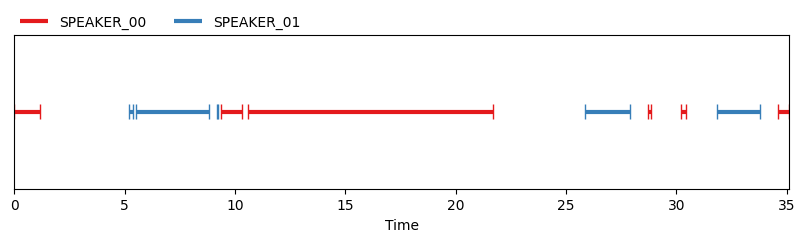

In [20]:
create_annotation_plot(video_output)

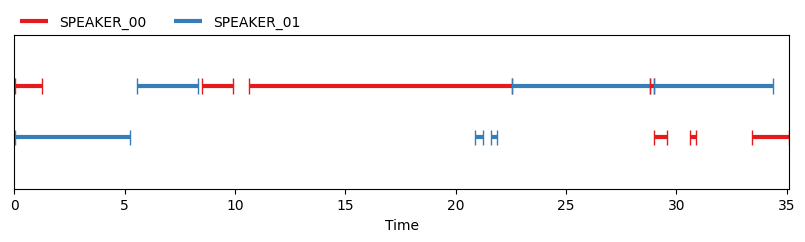

In [21]:
create_annotation_plot(audio_output)

In [22]:
video_audio_mapping = get_video_to_audio_mapping(video_output, audio_output)
video_audio_mapping

{'SPEAKER_00': 'SPEAKER_00', 'SPEAKER_01': 'SPEAKER_01'}

In [23]:
df = generate_openai_transcription(args.videoPath, model)

Transcribe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 38.13/38.13 [00:03<00:00, 11.46sec/s]


In [24]:
df["segment_end"] = df.apply(
    lambda row: (row["segment_end"] + 0.1) if row["segment_start"] == row["segment_end"] else row["segment_end"], axis=1
)
df["word_end"] = df.apply(
    lambda row: (row["word_end"] + 0.1) if row["word_start"] == row["word_end"] else row["word_end"], axis=1
)
segment_df = df[["segment_id", "segment_text", "segment_start", "segment_end"]].drop_duplicates().reset_index(drop=True)
word_df = df[["segment_id", "word", "word_start", "word_end"]]
segment_df["speaker_output"] = segment_df.apply(
    lambda row: get_segment_to_speaker_mapping(
        row["segment_start"], row["segment_end"], video_audio_mapping, audio_output
    ),
    axis=1,
)
segment_df["speaker_key"] = segment_df["speaker_output"].apply(lambda x: x[0])
segment_df["speaker_confidence"] = segment_df["speaker_output"].apply(lambda x: x[1])

In [25]:
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{row['speaker_key']}: {row['segment_text']}"
    ),
    axis=1
)

In [26]:
# If name mapping known
name_mapping = {"SPEAKER_00": "Trump", "SPEAKER_01": "Piers"}
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{name_mapping[row['speaker_key']]}: {row['segment_text']}"
    ),
    axis=1
)

In [27]:
srt_string = srt.compose(segment_df["Subtitles"].to_list())
with open(os.path.join(args.savePath, args.videoName + datetime.now().strftime("_%Y%m%d_%H%M%S") + ".srt"),
          "w",
         ) as f:
    f.write(srt_string)